# Programming exercise 8: Anomaly detection and recommender systems

Here are my solutions for this exercise. Here are my solutions for this exercise.
* Jupyter notebook template modified from: https://github.com/dibgerge/ml-coursera-python-assignments.


In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy import optimize

## 1 Anomaly detection

Data information
------------------
Data		Shape
X		(307, 2)
Xval		(307, 2)
yval		(307, 1)
Visualizing example dataset for outlier detection


Text(0.5, 1.0, 'Example dataset 1')

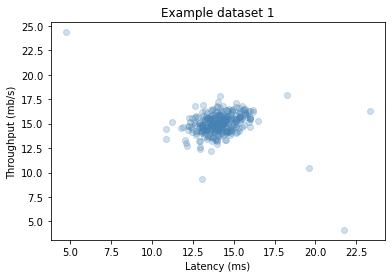

In [2]:
# Load example dataset
data = sio.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']
print(f'Data information\n------------------')
print(f'Data\t\tShape')
print(f'X\t\t{X.shape}')
print(f'Xval\t\t{Xval.shape}')
print(f'yval\t\t{yval.shape}')

print('Visualizing example dataset for outlier detection')
plt.scatter(X[:, 0], X[: , 1], color='steelblue', alpha=0.25)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Example dataset 1')

### 1.1 Gaussian distribution
To perform anomaly detection, we will first need to fit a model to the data's distribution. Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 \dots n$, find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i^{th}$ dimension $\{ x_i^{(1)}, \dots, x_i^{(m)} \}$ (the $i^{th}$ dimension of each example).

The Gaussian distribution is given by
$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$

where $\mu$ is the mean and $\sigma^2$ is the variance.

### 1.2 Estimating parameters for a Gaussian distribution
Estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, use:
$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance use:
$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

In [3]:
def estimateGaussian(X):
    """
    This function estimates the parameters of a Gaussian distribution
    using a provided dataset.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n) with each n-dimensional 
        data point in one row, and each total of m data points.
    
    Returns
    -------
    mu : array_like 
        A vector of shape (n,) containing the means of each dimension.
    
    sigma2 : array_like
        A vector of shape (n,) containing the computed
        variances of each dimension.
    
    """
    # Initialize important parameters
    m, n = X.shape
    
    # Calculate mu
    mu = np.mean(X, axis=0)
    
    # Calculate sigma
    sigma2 = np.square(np.std(X, axis=0, ddof=1))
    
    return mu, sigma2

In [4]:
def multivariateGaussian(X, mu, sigma2):
    """
    Computes the probability density function of the multivariate gaussian distribution.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n). Where there are m examples of n-dimensions.
    
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    
    Sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    
    Returns
    ------
    p : array_like
        A vector of shape (m,) which contains the computed probabilities at each of the
        provided examples.
    
    """
    
    # Initialize important parameters
    m, n = X.shape
    
    # Convert to covariance matrix if sigma2 is a vector
    if sigma2.ndim == 1:
        sigma2 = np.diag(sigma2)

    # Mutlivariate gaussian distribution
    X = X - mu
    p = (2 * np.pi) ** (- n / 2) * np.linalg.det(sigma2) ** (-0.5)\
        * np.exp(-0.5 * np.sum(np.dot(X, np.linalg.pinv(sigma2)) * X, axis=1))
    
    return p

In [5]:
def visualizeFit(X, mu, sigma2):
    """
    Visualize the dataset and its estimated distribution.
    This visualization shows you the  probability density function of the Gaussian distribution.
    Each example has a location (x1, x2) that depends on its feature values.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x 2). Where there are m examples of 2-dimensions. We need at most
        2-D features to be able to visualize the distribution.
    
    mu : array_like
        A vector of shape (n,) contains the means for each dimension (feature).
    
    sigma2 : array_like
        Either a vector of shape (n,) containing the variances of independent features
        (i.e. it is the diagonal of the correlation matrix), or the full
        correlation matrix of shape (n x n) which can represent dependent features.
    
    """
    # Initialize important parameters
    m, n = X.shape

    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    X_gaus = np.stack([X1.ravel(), X2.ravel()], axis=1)
    Z = multivariateGaussian(X_gaus, mu, sigma2)
    Z = Z.reshape(X1.shape)
    
    plt.scatter(X[:, 0], X[: , 1], color='steelblue', alpha=0.25)
    if np.all(abs(Z) != np.inf):
        plt.contour(X1, X2, Z, 10.0 ** np.arange(-20, 0, 3), 
                    linewidths=1, cmap='RdYlBu', alpha=0.5, zorder=100)
        plt.contourf(X1, X2, Z, 10.0 ** np.arange(-20, 0, 3),
                     cmap='RdBu', alpha=0.1, zorder=100)
    
    plt.xlim(0, 30)
    plt.ylim(0, 30)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    plt.title('Gaussian distribution')
    plt.colorbar()

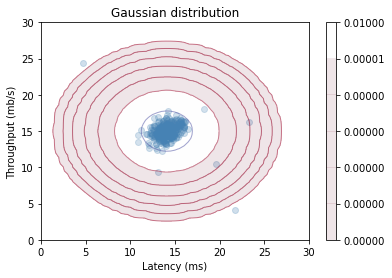

In [6]:
mu, sigma2 = estimateGaussian(X)
visualizeFit(X, mu, sigma2)

### 1.3 Selecting the threshold, $\epsilon$

In [7]:
def selectThreshold(yval, pval):
    """
    Find the best threshold (epsilon) to use for selecting outliers based
    on the results from a validation set and the ground truth.
    
    Parameters
    ----------
    yval : array_like
        The ground truth labels of shape (m, ).
    
    pval : array_like
        The precomputed vector of probabilities based on mu and sigma2 parameters. It's shape is also (m, ).
    
    Returns
    -------
    bestEpsilon : array_like
        A vector of shape (n,) corresponding to the threshold value.
    
    bestF1 : float
        The value for the best F1 score.
        
    """
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    step_size = (np.max(pval) - np.min(pval)) / 1000
    
    for epsilon in np.arange(min(pval), max(pval), step_size):
        pred = pval < epsilon
        tp = np.sum(pred[np.nonzero(yval.ravel() == True)])
        fp = np.sum(pred[np.nonzero(yval.ravel() == False)])
        fn = np.sum(yval.ravel()[np.nonzero(pred == False)] == True)
        
        if tp != 0:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            F1 = (2 * precision * recall) / (precision + recall)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        
    return bestEpsilon, bestF1

In [8]:
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print ('Best epsilon found using cross-validation:', epsilon)
print ('Best F1 on Cross Validation Set:', F1)
print ('(you should see a value epsilon of about 8.99e-05)')

Best epsilon found using cross-validation: 8.961567687193518e-05
Best F1 on Cross Validation Set: 0.8750000000000001
(you should see a value epsilon of about 8.99e-05)


Text(0.5, 1.0, 'Example dataset 1')

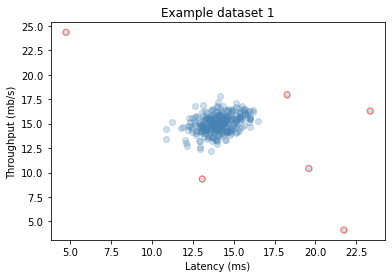

In [9]:
# Find anomalies
pval = multivariateGaussian(X, mu, sigma2)
anomalies = X[pval < epsilon]

# Draw circles around outliers
plt.scatter(X[:, 0], X[: , 1], color='steelblue', alpha=0.25)
plt.scatter(anomalies[:, 0], anomalies[: , 1], facecolors='none', color='tomato', alpha=0.90)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.title('Example dataset 1')

### 1.4 High dimensional dataset

In [10]:
# Load dataset
data = sio.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

print(f'Data information\n------------------')
print(f'Data\t\tShape')
print(f'X\t\t{X.shape}')
print(f'Xval\t\t{Xval.shape}')
print(f'yval\t\t{yval.shape}')

Data information
------------------
Data		Shape
X		(1000, 11)
Xval		(100, 11)
yval		(100, 1)


In [11]:
# Estimate Gaussian
mu, sigma2 = estimateGaussian(X)

# Determine best epsilon and F1
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

print ('Best epsilon found using cross-validation:', epsilon)
print ('(you should see a value epsilon of about 1.38e-18)')
print ('Best F1 on Cross Validation Set:', F1)
print ('(you should see a best F1 of about 0.615385)')

# Determine number of outliers
p = multivariateGaussian(X, mu, sigma2)
outliers = len(X[p < epsilon])
print ('\nOutliers found: ', outliers)

Best epsilon found using cross-validation: 1.3716606750407334e-18
(you should see a value epsilon of about 1.38e-18)
Best F1 on Cross Validation Set: 0.6153846153846154
(you should see a best F1 of about 0.615385)

Outliers found:  117


### 1.5 Additional notes: Coding rationale for F1

In [ ]:
pred = pval < epsilon # np.array with anomalies filtered by threshold

# True positives
positives = yval.ravel() == True # Truth table of anomalies in yval
pos_indices = np.nonzero(positives) # Non-zero indices in yval == True
tp = pred[pos_indices] # Corresponding results for pred
np.sum(tp) # Number of true positives in pred (excludes False)

In [ ]:
# False positives
negatives = yval.ravel() == False # Truth table of normal values in yval
neg_indices = np.nonzero(negatives) # Non-zero indices in yval == False
fp = pred[neg_indices] # Corresponding results for pred
np.sum(fp) # Number of false positives in pred (excludes False)

In [ ]:
# False negatives
negatives_pred = pred == False # Truth table for normal values in pred
neg_indices_pred = np.nonzero(negatives_pred) # Non-zero indices in pred == False
fn = yval[neg_indices_pred] # Corresponding results for yval
fn = fn == True # Truth table for values in yval which are positive
np.sum(fn)

## 2 Recomender systems
In this part of the exercise, implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings (MovieLens 100k Dataset from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

### 2.1 Movie ratings dataset

In [2]:
# Load movie ratings dataset
data = sio.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']
print('Data information')
print(f'Y is a {Y.shape[0]}x{Y.shape[1]} matrix, comprising ratings (1-5) of {Y.shape[0]} movies from {Y.shape[1]} users')
print(f'R is a {R.shape[0]}x{R.shape[1]} matrix, where R(i, j) = 1 if user j provided a rating to movie i')

Data information
Y is a 1682x943 matrix, comprising ratings (1-5) of 1682 movies from 943 users
R is a 1682x943 matrix, where R(i, j) = 1 if user j provided a rating to movie i


In [3]:
# Compute statistics
print (f'Average rating for movie 1 (Toy Story):\t {np.mean(Y[0, R[0, :]])}')

Average rating for movie 1 (Toy Story):	 4.52067868504772


Text(0, 0.5, 'Movies')

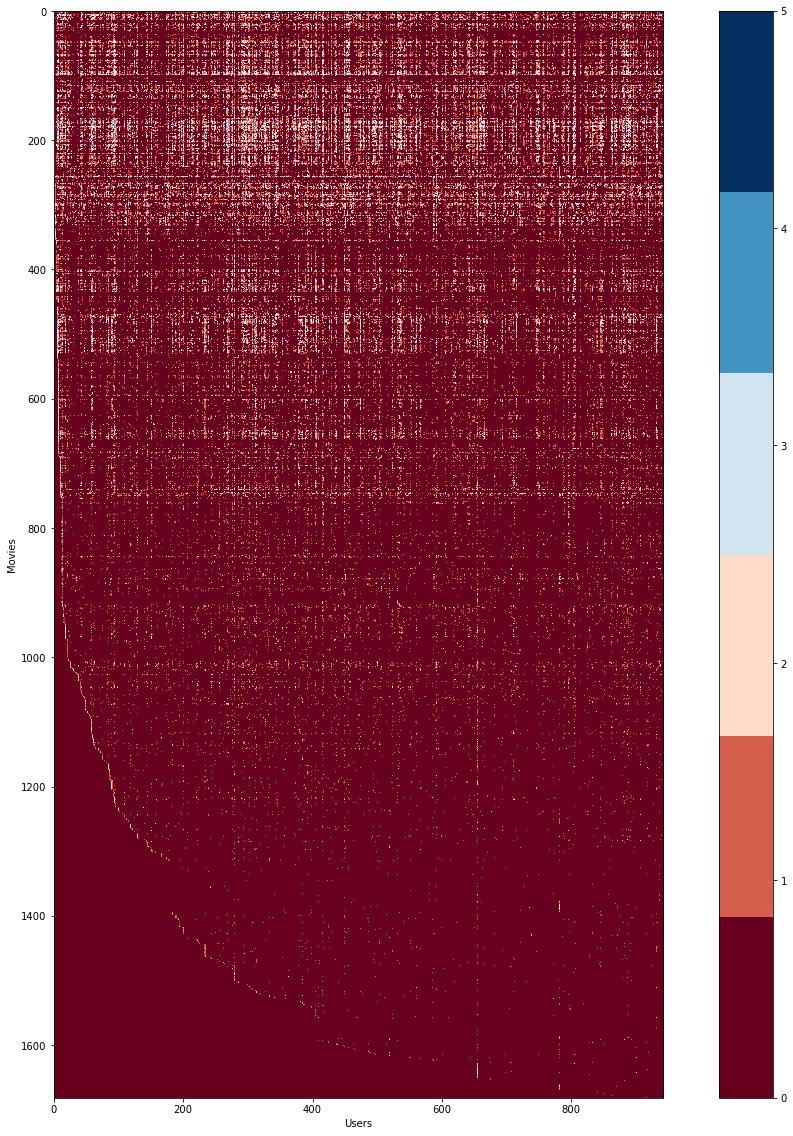

In [4]:
# Visualize ratings
plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(Y, cmap=plt.cm.get_cmap('RdBu', 6))
plt.colorbar()
plt.xlabel('Users')
plt.ylabel('Movies')

# Reset figure to default
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

# References
# https://jakevdp.github.io/PythonDataScienceHandbook/04.07-customizing-colorbars.html
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

### 2.2 Collaborative filterning learning algorithm

#### 2.2.1 Collaborative filtering cost function
The collaborative filtering cost function (without regularization) is given by
$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2 $$

In [5]:
# Load pretrained weights
data = sio.loadmat('ex8_movieParams.mat')
X = data['X']
Theta = data['Theta']
num_users = data['num_users']
num_movies = data['num_movies']
num_features = data['num_features']

print(f'Data information')
print(f'Data\t\tShape\n------------------------')
print(f'X\t\t{X.shape}')
print(f'Theta\t\t{Theta.shape}')
print(f'num_users\t{num_users.shape}')
print(f'num_movies\t{num_movies.shape}')
print(f'num_features\t{num_features.shape}')

Data information
Data		Shape
------------------------
X		(1682, 10)
Theta		(943, 10)
num_users	(1, 1)
num_movies	(1, 1)
num_features	(1, 1)


In [6]:
# Reduce dataset
num_users = 4
num_movies = 5
num_features = 3

X = X[0:num_movies, 0:num_features]
Theta = Theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

print(f'Data information')
print(f'Data\t\tShape\n------------------------')
print(f'X\t\t{X.shape}')
print(f'Theta\t\t{Theta.shape}')
print(f'Y\t\t{Y.shape}')
print(f'R\t\t{R.shape}')

Data information
Data		Shape
------------------------
X		(5, 3)
Theta		(4, 3)
Y		(5, 4)
R		(5, 4)


In [7]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_):
    """
    Collaborative filtering cost function.
    
    Parameters
    ----------
    params : array_like
        The parameters which will be optimized. This is a one
        dimensional vector of shape (num_movies x num_users, 1). It is the 
        concatenation of the feature vectors X and parameters Theta.
    
    Y : array_like
        A matrix of shape (num_movies x num_users) of user ratings of movies.
    
    R : array_like
        A (num_movies x num_users) matrix, where R[i, j] = 1 if the 
        i-th movie was rated by the j-th user.
    
    num_users : int
        Total number of users.
    
    num_movies : int
        Total number of movies.
    
    num_features : int
        Number of features to learn.
    
    lambda_ : float, optional
        The regularization coefficient.
    
    Returns
    -------
    J : float
        The value of the cost function at the given params.
    
    grad : array_like
        The gradient vector of the cost function at the given params.
        grad has a shape (num_movies x num_users, 1)

    """
    
    # Unfold param matrices
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)
    
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # Cost function
    hypothesis = X.dot(Theta.T) * R # To select users who have rated the movie
    J = (0.5) * np.sum(np.square(hypothesis - Y))
    J += (lambda_ / 2) * np.sum(np.square(Theta)) + \
         (lambda_ / 2) * np.sum(np.square(X))
    
    # Gradient descent
    X_grad = (hypothesis - Y).dot(Theta)
    X_grad += lambda_ * X
    
    Theta_grad = (hypothesis - Y).T.dot(X)
    Theta_grad += lambda_ * Theta
    
    grad = np.concatenate([X_grad.ravel(), Theta_grad.ravel()])
    
    return J, grad

In [8]:
lambda_ = 0
params = np.concatenate([X.ravel(), Theta.ravel()])
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lambda_)
print('Cost at loaded parameters:  %.2f \n(this value should be about 22.22)' % J)

Cost at loaded parameters:  22.22 
(this value should be about 22.22)


In [9]:
def checkCostFunction(cofiCostFunc, lambda_=0):
    """
    Creates a collaborative filtering problem to check your cost function and gradients.
    It will output the  analytical gradients produced by your code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result
    in very similar values.
    
    Parameters
    ----------
    cofiCostFunc: func
        Implementation of the cost function.
    
    lambda_ : float, optional
        The regularization parameter.
    """
    
    # Create a small temporary dataset
    X_temp = np.random.rand(4, 3)
    Theta_temp = np.random.rand(5, 3)
    
    Y = X_temp.dot(Theta_temp.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0 # set certain values to zero
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run gradient checking
    X = np.random.randn(*X_temp.shape)
    Theta = np.random.randn(*Theta_temp.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_temp.shape[1]
    
    params = np.concatenate([X.ravel(), Theta.ravel()])
    numgrad = computeNumericalGradient(
                    lambda x: cofiCostFunc(x, Y, R,
                                           num_users, num_movies, 
                                           num_features, lambda_), params)
    
    cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies,
                              num_features, lambda_)
    
    print(np.stack([numgrad, grad], axis=1))
    print('\nThe above two columns you get should be very similar.'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then '
          'the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: %g' % diff)

In [10]:
def computeNumericalGradient(J, theta, e=1e-1):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.
    
    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.
    theta : array_like
        The one dimensional unrolled network parameters. 
        The numerical gradient is computed at those given parameters.
    e : float (optional)
        The value to use for epsilon for computing the finite difference.
    
    Returns
    -------
    numgrad : array_like
        The numerical gradient with respect to theta. Has same shape as theta.
    
    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1) / (2 * e)
    
    return numgrad

In [11]:
checkCostFunction(cofiCostFunc, 0)

[[ 2.2942915   2.2942915 ]
 [-1.78992696 -1.78992696]
 [-0.83494467 -0.83494467]
 [-2.52857533 -2.52857533]
 [ 0.34302373  0.34302373]
 [-1.54895033 -1.54895033]
 [ 0.85452427  0.85452427]
 [-5.8459955  -5.8459955 ]
 [-5.41326811 -5.41326811]
 [-4.00994196 -4.00994196]
 [ 3.06211694  3.06211694]
 [-2.05736398 -2.05736398]
 [-0.68763231 -0.68763231]
 [ 3.01459978  3.01459978]
 [ 6.65302399  6.65302399]
 [ 1.32732732  1.32732732]
 [ 3.5399503   3.5399503 ]
 [ 5.16185958  5.16185958]
 [-0.66817984 -0.66817984]
 [ 1.03722446  1.03722446]
 [ 2.43927432  2.43927432]
 [10.07737289 10.07737289]
 [-3.23612173 -3.23612173]
 [-1.61958219 -1.61958219]
 [ 1.02857929  1.02857929]
 [-0.30090761 -0.30090761]
 [ 1.33404155  1.33404155]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 1.24672e-15


#### 2.2.3 Regularized cost function

In [12]:
# Evaluation cost function
J, _ = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters (lambda = 1.5): %.2f' % J)
print('              (this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.34
              (this value should be about 31.34)


#### 2.2.4 Regularized gradient descent

In [13]:
checkCostFunction(cofiCostFunc, 1.5)

[[-4.74702653 -4.74702653]
 [ 1.09495544  1.09495544]
 [ 1.04207149  1.04207149]
 [ 4.53769586  4.53769586]
 [-1.64689553 -1.64689553]
 [-0.02485661 -0.02485661]
 [-1.09193102 -1.09193102]
 [-0.87188269 -0.87188269]
 [ 0.94424291  0.94424291]
 [-9.50448373 -9.50448373]
 [-9.2569805  -9.2569805 ]
 [ 4.10260428  4.10260428]
 [ 6.70440985  6.70440985]
 [ 0.93748594  0.93748594]
 [-2.9412196  -2.9412196 ]
 [ 1.55300326  1.55300326]
 [-1.64852029 -1.64852029]
 [ 2.89607319  2.89607319]
 [ 7.77776257  7.77776257]
 [ 3.95445598  3.95445598]
 [-3.2310268  -3.2310268 ]
 [ 6.94976716  6.94976716]
 [-2.5770802  -2.5770802 ]
 [-1.39422398 -1.39422398]
 [-0.27247727 -0.27247727]
 [-0.36836255 -0.36836255]
 [-0.30966401 -0.30966401]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 2.68992e-15


### 2.3 Learning movie recomendations

In [14]:
import re
# Add ratings that correspond to a new user
with open('movie_ids.txt', 'r') as f:
    moviesList = f.read()

moviesList = re.sub('(\d+)\s', '', moviesList)
moviesList = moviesList.split('\n')
moviesList.pop(-1) # To  remove '' at end of list

# Initialize ratings
my_ratings = np.zeros((len(moviesList), 1))

# Rate movies
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings: ')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Rated {int(my_ratings[i])} for {moviesList[i]}')

New user ratings: 
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard (1990)
Rated 5 for Sphere (1998)


#### 2.3.1 Recomendations

In [17]:
# Train collaborative filtering model on movie ratings data set
data = sio.loadmat('ex8_movies.mat')
Y, R = data['Y'], data['R']

# Add own ratings to the data matrix
Y = np.hstack([my_ratings, Y])
R = np.hstack([(my_ratings > 0), R])

# Normalize ratings
Ynorm, Ymean = normalizeRatings(Y, R)

# Initialize useful values
num_movies, num_users = Y.shape
num_features = 10

# Set initial parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options
options = {'maxiter': 100}

# Set regularization
lambda_ = 10
costFunc = lambda x: cofiCostFunc(x, Ynorm, R, num_users, num_movies,
                                  num_features, lambda_)
result = optimize.minimize(costFunc,
                           initial_parameters,
                           method='TNC',
                           jac=True,
                           options=options)

theta = result.x

# Unfold the returned theta back to X and Theta
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed')

Recommender system learning completed


In [18]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).
    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).
    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).
    
    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.
    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)
    
    for i in range(m):
        index = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, index])
        Ynorm[i, index] = Y[i, index] - Ymean[i]
    
    return Ynorm, Ymean

In [22]:
p = X.dot(Theta.T)
my_predictions = p[:, 0] + Ymean

ix = np.argsort(my_predictions)[::-1]
print('Top recomendations for you:')
print('---------------------------')
for i in range(10):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], moviesList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], moviesList[i]))

Top recomendations for you:
---------------------------
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Santa with Muscles (1996)

Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Sile